## Gap Analysis: Analysis of False Negatives

In this section, we conduct a post-mortem gap analysis to examine patterns in our prediction errors to gain insight into where this model could be improved. To examine the gap between the model's expected performance and the actual results, we will evaluate how the F2 Score differs across the different airlines as well as over different times throughout the week. 

Here we just examine the held-out test data covering 2019, because we are most interested in the error patterns that arise with data the model has not seen before.

### Project Description
This is a group project conducted for course w261: Machine Learning at Scale at the University of California Berkeley in Summer 2023. This project develops a machine learning model that predicts flight delays based on historical flight, airport station, and weather data spanning five years from 2015-2019 in the United States.

###Group members
Jessica Stockham, Chase Madison, Kisha Kim, Eric Danforth

Citation: Code written by Chase Madison

In [0]:

from pyspark.sql.functions import avg, sum, count, when, col, floor, expr, first
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
## Place this cell in any team notebook that needs access to the team cloud storage
mids261_mount_path = '/mnt/mids-w261'  # 261 course blob storage is mounted here
secret_scope = 'sec5-team1-scope'  # Name of the secret scope Chase created in Databricks CLI
secret_key = 'sec5-team1-key'  # Name of the secret key Chase created in Databricks CLI
storage_account = 'sec5team1storage'  # Name of the Azure Storage Account Chase created
blob_container = 'sec5-team1-container'  # Name of the container Chase created in Azure Storage Account
team_blob_url = f'wasbs://{blob_container}@{storage_account}.blob.core.windows.net'  # Points to the root of your team storage bucket
spark.conf.set(  # SAS Token: Grant the team limited access to Azure Storage resources
  f'fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net',
  dbutils.secrets.get(scope=secret_scope, key=secret_key)
)

In [0]:
timeInterval = '60mo'
fold_name_clean = 'final_heldout_results_downsampled'
otpw_test = spark.read.format("parquet")\
    .option("path", (f"{team_blob_url}/{fold_name_clean}/nn_heldout_pred_df" + timeInterval))\
    .load().cache()

### Model Performance by Airline

First we look at how consistently our model performs across all airlines, big and small. Do we see a pattern that could indicate a systematic issue we might flag for future work?

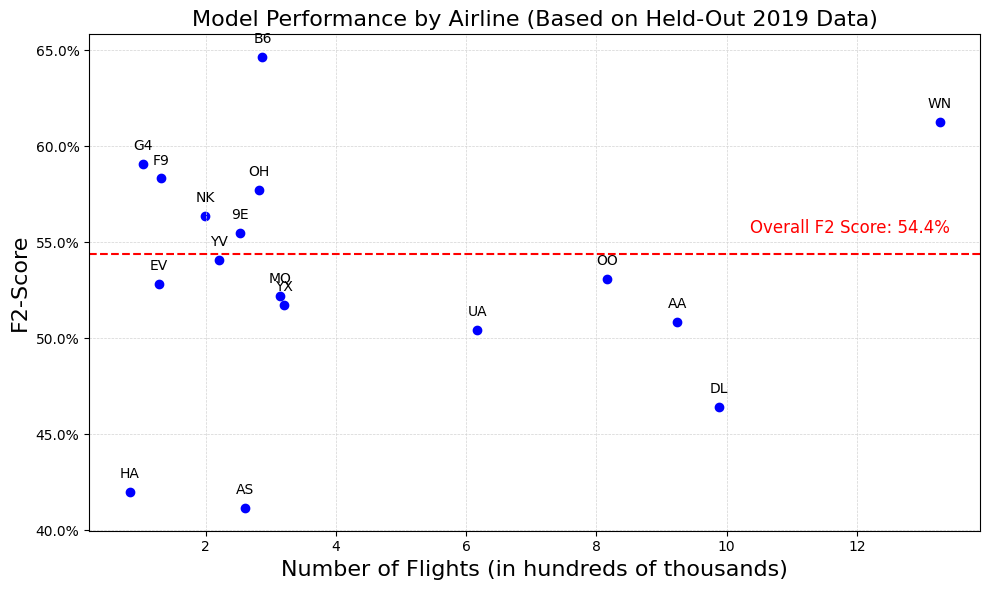

In [0]:
# Calculate true positives and false negatives
otpw_test = otpw_test.withColumn('true_positives', when((col('prediction') == 1) & (col('label') == 1), 1).otherwise(0)) \
    .withColumn('false_negatives', when((col('prediction') == 0) & (col('label') == 1), 1).otherwise(0))

# Calculate precision and recall
otpw_test_by_airline = otpw_test.groupBy('OP_UNIQUE_CARRIER') \
    .agg(
        count('*').alias('flight_count'),
        sum('label').alias('delayed_flights_actual'),
        sum('prediction').alias('delayed_flights_predicted'),
        sum('true_positives').alias('true_positives'),
        sum('false_negatives').alias('false_negatives'),
    ) \
    .selectExpr(
        "OP_UNIQUE_CARRIER",
        "flight_count",
        "delayed_flights_actual",
        "delayed_flights_predicted",
        "true_positives",
        "false_negatives",
        "flight_count",
        "true_positives / delayed_flights_predicted as precision",
        "true_positives / delayed_flights_actual as recall"
    ) \
    .where(col('flight_count') > 15)

# Calculate F2-score
beta = 2
f2_score_expr = (
    (1 + beta ** 2) * col('precision') * col('recall') /
    ((beta ** 2 * col('precision')) + col('recall'))
)

# Add the F2-score column and order by it
otpw_test_by_airline = otpw_test_by_airline.withColumn('f2_score', f2_score_expr) \
    .orderBy('f2_score')

# Extract relevant data from the DataFrame
airlines = otpw_test_by_airline.select('OP_UNIQUE_CARRIER').rdd.flatMap(lambda x: x).collect()
f2_scores = otpw_test_by_airline.select('f2_score').rdd.flatMap(lambda x: x).collect()
flight_counts = otpw_test_by_airline.select('flight_count').rdd.flatMap(lambda x: x).collect()

# Calculate overall F2 Score
overall_f2_score = 0.5438

# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(flight_counts, f2_scores, c='blue', marker='o')

# Add labels for each point (airline) with no overlap
label_offset = 0.05
label_positions = {}
for i, airline in enumerate(airlines):
    x = flight_counts[i]
    y = f2_scores[i]
    if y in label_positions:
        y += label_offset
    label_positions[y] = True
    plt.annotate(airline, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Add a line for the overall F2 Score and label it
plt.axhline(y=overall_f2_score, color='red', linestyle='--')

plt.annotate(
    f'Overall F2 Score: {overall_f2_score:.1%}', 
    xy=(1100000, overall_f2_score * 1.06),
    xycoords='data',
    xytext=(-30, -30),
    textcoords='offset points', 
    color='red',
    fontsize=12
)

# Format the Y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

# Set X-axis ticks to be in hundreds of thousands
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/100000:.0f}'))

# Add light grey gridlines
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)

# Change title
plt.title('Model Performance by Airline (Based on Held-Out 2019 Data)', fontsize=16)

# Labels and title
plt.xlabel('Number of Flights (in hundreds of thousands)', fontsize=16)
plt.ylabel('F2-Score', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

**Insights**
* From this plot, we can see that our model handles small airports well, except for Hawaii Air (HA) and Alaska Air (AS) who perform many more long-haul flights considering that they are headquartered outside of the continental United States. 
* Surprisingly, our model significantly underperforms on the major airlines United (UA), American (AA), and Delta (DL). This observation suggests the need for a closer examination of the underlying factors affecting the prediction accuracy for these airlines.
* Southwest Airlines (WN) emerges as a carrier that our model predicts with relative ease, potentially due to distinctive operational characteristics or patterns that align well with our model's features.

### Model Performance by Time of Week

Let's delve into the consistency of the model's performance across the different times of the week.

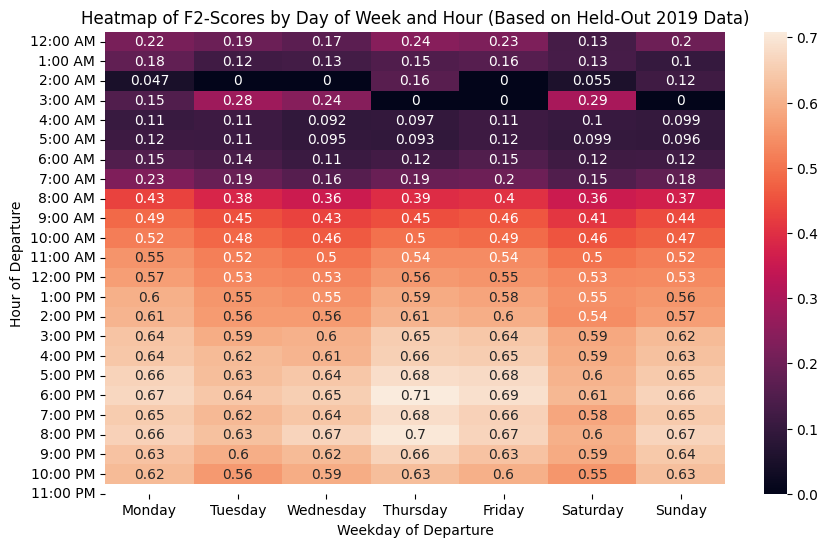

In [0]:
# Calculate true positives and false negatives
otpw_test = otpw_test.withColumn('true_positives', when((col('prediction') == 1) & (col('label') == 1), 1).otherwise(0)) \
    .withColumn('false_negatives', when((col('prediction') == 0) & (col('label') == 1), 1).otherwise(0))

# Calculate precision and recall by hour of day and day of week
otpw_test_by_time = otpw_test.withColumn('hour_of_day', floor(col('CRS_DEP_TIME') / 100)) \
    .groupBy('hour_of_day', 'DAY_OF_WEEK') \
    .agg(
        count('*').alias('flight_count'),
        sum('label').alias('delayed_flights_actual'),
        sum('prediction').alias('delayed_flights_predicted'),
        sum('true_positives').alias('true_positives'),
        sum('false_negatives').alias('false_negatives'),
    ) \
    .selectExpr(
        "hour_of_day",
        "DAY_OF_WEEK",
        "flight_count",
        "delayed_flights_actual",
        "delayed_flights_predicted",
        "true_positives",
        "false_negatives",
        "flight_count",
        "CASE WHEN delayed_flights_predicted > 0 THEN true_positives / delayed_flights_predicted ELSE 0 END as precision",
        "CASE WHEN delayed_flights_actual > 0 THEN true_positives / delayed_flights_actual ELSE 0 END as recall"
    ) \
    .where(col('flight_count') > 15)

# Calculate F2-score
beta = 2
f2_score_expr = (
    when(
        (col('precision') == 0) & (col('recall') == 0),
        0
    ).otherwise(
        (1 + beta ** 2) * col('precision') * col('recall') /
        ((beta ** 2 * col('precision')) + col('recall'))
    )
)

# Add the F2-score column and order by it
otpw_test_by_time = otpw_test_by_time.withColumn('f2_score', f2_score_expr) \
    .orderBy('f2_score')

# For our labels
def convert_to_12_hour_format(hour):
    if hour == 0:
        return "12:00 AM"
    elif 1 <= hour <= 11:
        return f"{hour}:00 AM"
    elif hour == 12:
        return "12:00 PM"
    else:
        return f"{hour - 12}:00 PM"
    
ordered_hour_names = [convert_to_12_hour_format(hour) for hour in range(24)]

ordered_day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Pivot the DataFrame to create a heatmap matrix
heatmap_data = otpw_test_by_time.groupby("hour_of_day").pivot("DAY_OF_WEEK").agg(first("f2_score")).orderBy('hour_of_day')

# Extract data for plotting
f2_score_matrix = heatmap_data.drop('hour_of_day').toPandas().values

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(f2_score_matrix, annot=True, xticklabels=ordered_day_names, yticklabels=ordered_hour_names)
plt.title("Heatmap of F2-Scores by Day of Week and Hour (Based on Held-Out 2019 Data)")
plt.xlabel("Weekday of Departure")
plt.ylabel("Hour of Departure")
plt.show()

**Insights**
* The model's performance is notably weak during times when flights are infrequent, particularly flights scheduled before 8:00 a.m.
* As the day progresses and more flights take place, the model's performance improves significantly.
* The model demonstrates better performance on weekdays compared to weekends.

### Recommendations for Further Improvement

Based on the above findings, we recommend the following feature engineering work done to further improve the model: 

* **Cross-Oceanic Flight Indicator**: Include a feature that distinguishes airlines that primarily carry out cross-oceanic flights. Currently, we account for the distance of the flight but there could also be a factor when traveling outside the contiguous 48 US states. 
* **Hour-of-Day Segmentation**: Include a feature that breaks out hour of the day similar to quartiles with differently-lengthed time spans. For example, there may be as many flights departing between 12am and 10am as there are departing between 10am and noon or between 5pm and 6pm. 
* **Weekend Indicator**: Provide a binary variable distinguishing the weekend from the weekdays to directly capture the difference in demands. Perhaps this difference stems from business vs. leisure travel.